In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default
import seaborn as sns

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [2]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict




def linreg(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train.recovery, y = y_pred.ravel())
    reg_df = pd.DataFrame(lr.coef_, columns=X_vars)
    reg_df = reg_df.transpose().sort_values(by=0, ascending=False)
    reg_df.rename(index=str, columns={0: 'value'}, inplace=True)
    abs_df = reg_df.copy()
    abs_df['value'] = abs(abs_df['value'])
    abs_df.sort_values(by='value', ascending=False)
    return reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter

def ridge(X_train, y_train):
    rr = Ridge(alpha=.5)
    rr.fit(X_train, y_train)
    y_pred = rr.predict((X_train))
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train, y = y_pred.ravel())
    return rr, rr.coef_, rr.intercept_, MAE, MSE, y_pred, scatter

def svm(X_train, y_train):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
    y_rbf = svr_rbf.fit(X_train, y_train).predict(X_train)
    y_lin = svr_lin.fit(X_train, y_train).predict(X_train)
    y_poly = svr_poly.fit(X_train, y_train).predict(X_train)
    MSE_rbf = mean_squared_error(y_train, y_rbf)
    MSE_lin = mean_squared_error(y_train, y_lin)
    MSE_poly = mean_squared_error(y_train, y_poly)
    return svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly

In [3]:
df = acquire_oil()
df = prep_data(df)
df.reset_index(inplace=True)
df.shape

(7888, 39)

In [4]:
df.isnull().sum()

index                 0
api14                 0
lease_name            0
well_number           0
county                0
direction             0
status                0
oper                  0
multi_well_lease      0
major_phase           0
formation             0
proppant_ppf          0
prod_method           0
frac_fluid_gpf        0
gross_perfs           0
frac_stages           0
frac_fluid_type       0
first_prod            0
last_prod             0
oil_gravity           0
peak_boepd            0
oil_hist              0
gas_hist              0
gor_hist              0
ip90_boeqpd           0
tvd                   0
sur_lat               0
sur_long              0
well_id               0
mid_point_lat         0
mid_point_long        0
sub-basin             0
recovery              0
recovery_per_foot     0
months_active         0
recovery_per_month    0
lateral_class         0
vintage               0
vintage_bin           0
dtype: int64

In [5]:
df.drop(columns=['api14', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat', 
                 'mid_point_long', 'tvd']).describe()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,recovery,recovery_per_foot,months_active,recovery_per_month,vintage,vintage_bin
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,1129.177020,1142.213462,5732.858773,3.204488,1.862447,508.725133,120.070635,385.288562,3888.944514,349.246186,152.154977,36.226277,60.276242,inf,2011.733266,4.485548
std,656.539972,714.303891,2945.296014,9.336062,9.188722,443.645469,95.660116,387.207769,3815.982884,315.135247,140.362192,61.383543,60.115080,NaN,8.202743,0.780967
min,1.098097,0.354610,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,0.013000,0.002991,0.000000,0.590909,1958.000000,1.000000
25%,525.892109,499.423181,4056.250000,0.000000,0.000000,159.810463,46.481500,110.739000,1422.937793,94.906605,57.693208,14.000433,32.000000,1071.903909,2012.000000,4.000000
50%,1156.356260,1222.371400,6242.000000,0.000000,0.000000,429.084519,101.236000,284.305000,2491.502805,292.328796,125.145754,22.247945,49.000000,2688.833781,2014.000000,5.000000
75%,1594.793975,1653.074860,7723.250000,0.000000,0.000000,732.588900,172.310750,542.369000,4906.603828,508.700090,196.330132,36.956724,66.000000,4944.219785,2015.000000,5.000000
max,3969.384520,2997.879640,13581.000000,70.000000,68.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,999.305470,997.824074,726.000000,inf,2018.000000,5.000000


## Standardize Numeric Data

In [6]:
numerics = ['int64', 'float64', 'float']

num_df = df.select_dtypes(include=numerics)
num_df = num_df.drop(columns=['gas_hist', 'recovery_per_foot', 
                              'recovery_per_month', 'api14',
#                              'landing_depth', sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long',
                             'well_id', 'oil_hist'])

### Use LabelEncoder to encode county, frac_fluid_type, oper, type, and formation.

In [7]:
df.select_dtypes(exclude=numerics).columns

Index(['index', 'lease_name', 'well_number', 'county', 'direction', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'prod_method',
       'frac_fluid_type', 'first_prod', 'last_prod', 'sub-basin',
       'lateral_class'],
      dtype='object')

In [8]:
# Not encoding: 'index', 'lease_name', 'well_number', 'status',
#               'multi_well_lease', 'major_phase', 'prod_method',
#               'first_prod', 'last_prod'

for col in ['county', 'direction', 'oper', 'formation', 'frac_fluid_type', 
            'sub-basin', 'lateral_class']:
    encoder = LabelEncoder()
    encoder.fit(df[col])
    num_df[col] = encoder.transform(df[col])
num_df.head()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,oper,formation,frac_fluid_type,sub-basin,lateral_class
0,1311.78809,1642.58887,3977.0,0.0,0.0,61.408554,1738.53259,47.452900,10021.0,32.434761,...,33,2016,5,0,0,66,29,7,2,3
1,1088.56238,1493.36900,7283.0,0.0,0.0,416.961182,1381.57100,351.796700,9764.0,32.124361,...,66,2013,4,0,0,52,29,3,2,0
2,951.97060,1369.34363,7382.0,0.0,0.0,838.371765,1961.41300,688.525400,10798.0,32.351297,...,64,2013,4,0,0,166,29,0,2,0
3,1155.36267,1299.68433,7382.0,31.0,0.0,438.325684,1325.53870,406.427765,9506.0,32.345441,...,63,2013,4,0,0,166,29,3,2,0
4,1284.25537,1596.72742,7050.0,0.0,0.0,443.969543,2816.79077,289.934052,10138.0,32.293814,...,59,2014,5,0,0,52,29,7,2,0


## Scale the data:

In [9]:
gross_perfs_scaled_limit = (6000 - num_df.gross_perfs.min()) / (num_df.gross_perfs.max() - num_df.gross_perfs.min())

In [10]:
gross_perfs_scaled_limit

0.44162922589673714

In [77]:
scaled_df = num_df.copy()
scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['gross_perfs'] = (scaled_df.gross_perfs - scaled_df.gross_perfs.min()) / (scaled_df.gross_perfs.max() - scaled_df.gross_perfs.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())
scaled_df['county'] = (scaled_df.county - scaled_df.county.min()) / (scaled_df.county.max() - scaled_df.county.min())
scaled_df['frac_fluid_type'] = (scaled_df.frac_fluid_type - scaled_df.frac_fluid_type.min()) / (scaled_df.frac_fluid_type.max() - scaled_df.frac_fluid_type.min())
scaled_df['oper'] = (scaled_df.oper - scaled_df.oper.min()) / (scaled_df.oper.max() - scaled_df.oper.min())
scaled_df['direction'] = (scaled_df.direction - scaled_df.direction.min()) / (scaled_df.direction.max() - scaled_df.direction.min())
scaled_df['formation'] = (scaled_df.formation - scaled_df.formation.min()) / (scaled_df.formation.max() - scaled_df.formation.min())
scaled_df['tvd'] = (scaled_df.tvd - scaled_df.tvd.min()) / (scaled_df.tvd.max() - scaled_df.tvd.min())
scaled_df['sur_lat'] = (scaled_df.sur_lat - scaled_df.sur_lat.min()) / (scaled_df.sur_lat.max() - scaled_df.sur_lat.min())
scaled_df['sur_long'] = (scaled_df.sur_long - scaled_df.sur_long.min()) / (scaled_df.sur_long.max() - scaled_df.sur_long.min())
scaled_df['mid_point_lat'] = (scaled_df.mid_point_lat - scaled_df.mid_point_lat.min()) / (scaled_df.mid_point_lat.max() - scaled_df.mid_point_lat.min())
scaled_df['mid_point_long'] = (scaled_df.mid_point_long - scaled_df.mid_point_long.min()) / (scaled_df.mid_point_long.max() - scaled_df.mid_point_long.min())
scaled_df['sub-basin'] = (scaled_df['sub-basin'] - scaled_df['sub-basin'].min()) / (scaled_df['sub-basin'].max() - scaled_df['sub-basin'].min())
scaled_df['lateral_class'] = (scaled_df.lateral_class - scaled_df.lateral_class.min()) / (scaled_df.lateral_class.max() - scaled_df.lateral_class.min())

#scaled_df['recovery'] = (scaled_df.recovery - scaled_df.recovery.min()) / (scaled_df.recovery.max() - scaled_df.recovery.min())
scaled_df.rename(index=str, columns={"oper": "operator"}, inplace=True)

In [78]:
scaled_df.sample(10)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
2044,0.453320,0.499776,0.521176,0.000000,0.0,0.132486,0.336366,0.114552,0.478487,0.236980,...,0.082645,0.933333,5,0.432432,0.0,0.011364,0.763158,0.875,1.0,0.000000
5146,0.502374,0.593637,0.717316,0.000000,0.0,0.087763,0.043160,0.062015,0.561188,0.219866,...,0.034435,0.983333,5,0.702703,0.0,0.314394,0.763158,0.875,1.0,0.692308
1534,0.042684,0.031519,0.039626,0.000000,0.0,0.002187,0.000175,0.002413,0.000000,0.565346,...,0.340220,0.650000,3,0.405405,1.0,0.719697,0.552632,0.250,1.0,0.461538
2361,0.409849,0.501723,0.612727,0.000000,0.0,0.057801,0.411923,0.060197,0.502382,0.196980,...,0.068871,0.950000,5,0.432432,0.0,0.314394,0.763158,0.875,1.0,0.384615
5591,0.275723,0.346192,0.552626,0.000000,0.0,0.074773,0.065156,0.092498,0.674334,0.328402,...,0.075758,0.933333,5,0.918919,0.0,0.628788,0.763158,0.375,1.0,0.000000
5400,0.055408,0.078944,0.207041,0.000000,0.0,0.117811,0.933353,0.098667,0.824177,0.279478,...,0.203857,0.800000,4,0.918919,0.0,0.818182,0.184211,0.375,1.0,0.846154
758,0.379599,0.703133,0.010901,0.000000,0.0,0.002689,0.277215,0.002026,0.000000,0.427307,...,0.059229,0.916667,4,0.351351,1.0,0.465909,0.657895,0.875,1.0,0.461538
5735,0.280626,0.544467,0.692568,0.000000,0.0,0.066536,0.118788,0.065872,0.685946,0.372902,...,0.056474,0.950000,5,0.918919,0.0,0.996212,0.763158,0.375,1.0,0.692308
4253,0.282404,0.321194,0.499521,0.342857,0.0,0.050990,0.076354,0.052531,0.566771,0.229316,...,0.121212,0.883333,4,0.702703,0.0,0.314394,0.763158,0.375,1.0,0.538462
302,0.243546,0.292039,0.519923,0.000000,0.0,0.075274,0.276560,0.075726,0.466875,0.190950,...,0.090909,0.916667,4,0.162162,0.0,0.738636,0.763158,0.875,1.0,0.000000


## Visualize Data

### Attribute Histograms

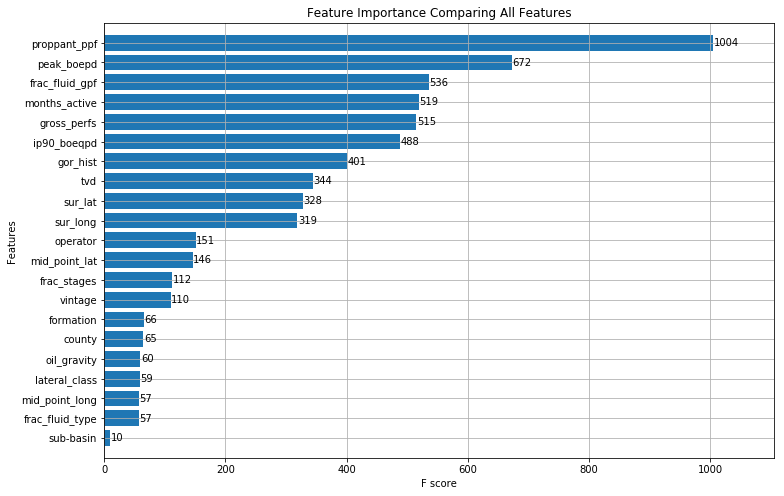

In [79]:
xgb_df = scaled_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, scaled_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance Comparing All Features')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

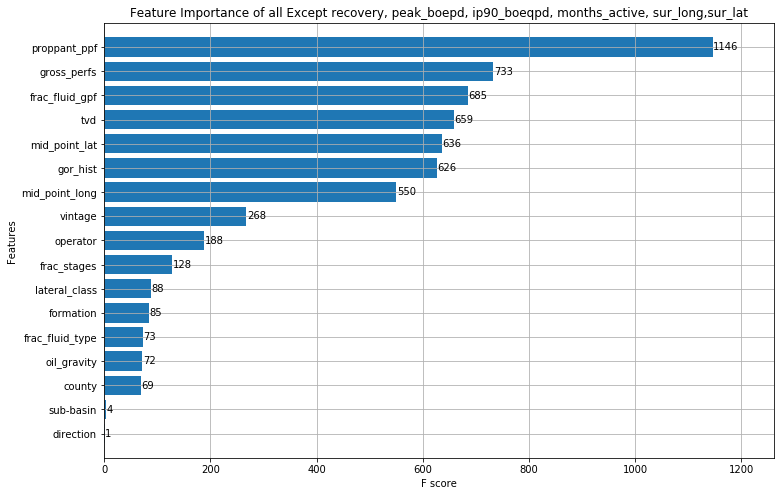

In [80]:
xgb_df = scaled_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, scaled_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of all Except recovery, peak_boepd, ip90_boeqpd, months_active, sur_long,sur_lat')
plt.show()

#### Run the regression with all of the features:

In [81]:
scaled_df.columns

Index(['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 'recovery',
       'months_active', 'vintage', 'vintage_bin', 'county', 'direction',
       'operator', 'formation', 'frac_fluid_type', 'sub-basin',
       'lateral_class'],
      dtype='object')

MAE: 34.1946357557332
MSE: 9145.000331985724
lr.intercept: -36.857294864076636


,value
mid_point_long,5272.546213
mid_point_lat,1357.768027
peak_boepd,824.124251
ip90_boeqpd,555.901137
months_active,264.100940
oil_gravity,110.583050
tvd,55.786105
gross_perfs,51.290886
gor_hist,43.440777
formation,39.753075


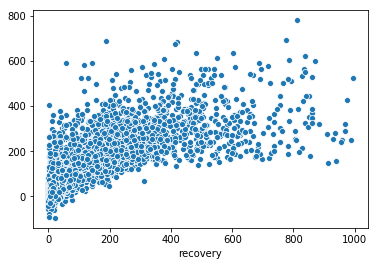

In [82]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 
       'months_active', 'vintage', 'vintage_bin', 'county', 'direction',
       'operator', 'formation', 'frac_fluid_type', 'sub-basin',
       'lateral_class']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [83]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
sur_long,5278.324232
mid_point_long,5272.546213
mid_point_lat,1357.768027
sur_lat,1341.953899
peak_boepd,824.124251
ip90_boeqpd,555.901137
months_active,264.100940
oil_gravity,110.583050
proppant_ppf,82.265370
tvd,55.786105


#### Filter all features for only vertical wells:

MAE: 9.402799335712203
MSE: 627.5733686861529
lr.intercept: -5.200914394817559


,value
mid_point_lat,2.328066e+04
sur_long,1.370648e+04
peak_boepd,1.136558e+03
ip90_boeqpd,7.184808e+02
gross_perfs,1.675348e+02
months_active,1.332890e+02
gor_hist,2.455360e+01
tvd,1.658407e+01
frac_fluid_gpf,1.438369e+01
sub-basin,7.771170e+00


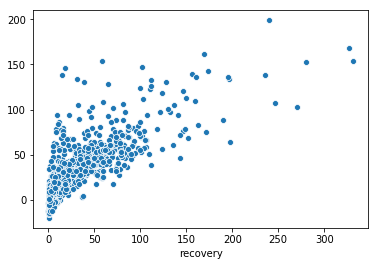

In [84]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 
       'months_active', 'vintage', 'vintage_bin', 'county', 'direction',
       'operator', 'formation', 'frac_fluid_type', 'sub-basin',
       'lateral_class']

# Dependent (target) variable, it is continuous
target = ['recovery']

# These lines are to filter for only vertical wells:
df_vert = scaled_df[scaled_df.direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [85]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
sur_lat,2.328975e+04
mid_point_lat,2.328066e+04
mid_point_long,1.372803e+04
sur_long,1.370648e+04
peak_boepd,1.136558e+03
ip90_boeqpd,7.184808e+02
frac_stages,2.681571e+02
gross_perfs,1.675348e+02
months_active,1.332890e+02
gor_hist,2.455360e+01


#### Test only top features suggested by XGBoost (exclude peak_boepd), without filtering for vertical wells.

MAE: 36.349632188969
MSE: 10058.453551352068
lr.intercept: -15.582055541666449
reg_df:


,value
ip90_boeqpd,1243.310392
months_active,270.961078
gross_perfs,78.879220
gor_hist,78.061420
tvd,64.670493
sur_lat,39.913448
frac_fluid_gpf,-6.070512
proppant_ppf,-25.629898
sur_long,-53.543145


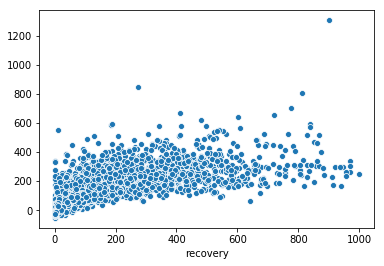

In [86]:
# Independent variables:
# X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
#           'months_active', 'lateral_len', 'ip90_boeqpd', 'county']
X_vars = ['proppant_ppf', 'gor_hist', 'gross_perfs', 'frac_fluid_gpf', 
          'months_active', 'ip90_boeqpd', 'sur_lat', 'tvd', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
print('reg_df:')
reg_df

In [87]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
ip90_boeqpd,1243.310392
months_active,270.961078
gross_perfs,78.879220
gor_hist,78.061420
tvd,64.670493
sur_long,53.543145
sur_lat,39.913448
proppant_ppf,25.629898
frac_fluid_gpf,6.070512


#### Test only top features suggested by XGBoost (exclude peak_boepd), WITH filtering for vertical wells.

MAE: 9.904246032495765
MSE: 685.372674186925
lr.intercept: -0.9096745162193685
reg_df:


,value
ip90_boeqpd,1989.524716
gross_perfs,148.794425
months_active,143.591573
gor_hist,24.737198
tvd,14.827474
sur_lat,13.912039
frac_fluid_gpf,12.413547
proppant_ppf,-7.842341
sur_long,-29.265087


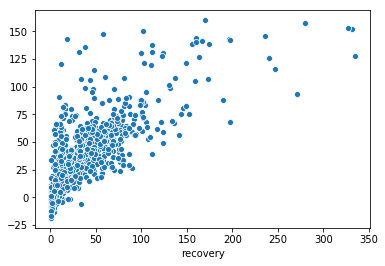

In [88]:
# Independent variables:
# X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
#           'months_active', 'lateral_len', 'ip90_boeqpd', 'county']
X_vars = ['proppant_ppf', 'gor_hist', 'gross_perfs', 'frac_fluid_gpf', 
          'months_active', 'ip90_boeqpd', 'sur_lat', 'tvd', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
print('reg_df:')
reg_df

In [89]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
ip90_boeqpd,1989.524716
gross_perfs,148.794425
months_active,143.591573
sur_long,29.265087
gor_hist,24.737198
tvd,14.827474
sur_lat,13.912039
frac_fluid_gpf,12.413547
proppant_ppf,7.842341


#### Run with features Joseph selected, with filtering for vertical wells:

MAE: 13.82850607192039
MSE: 1038.3099710672357
lr.intercept: 112.04918511182358


,value
gross_perfs,268.659496
tvd,43.193827
sur_lat,33.745133
proppant_ppf,16.648563
oil_gravity,-21.566693
sur_long,-48.884296
vintage,-110.959545
frac_stages,-350.191723


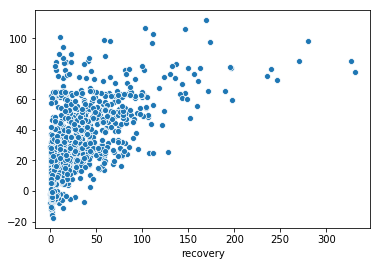

In [90]:
# Independent variables:
X_vars = ['gross_perfs', 'proppant_ppf', 'frac_stages', 'vintage', 
          'oil_gravity', 'tvd', 'sur_lat', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [91]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
frac_stages,350.191723
gross_perfs,268.659496
vintage,110.959545
sur_long,48.884296
tvd,43.193827
sur_lat,33.745133
oil_gravity,21.566693
proppant_ppf,16.648563


# Run XGBoost for each sub-basin:

#### CP, Central Platform:

In [92]:
CP_df = scaled_df[(scaled_df['sub-basin'] == 0)]
CP_df.sample(5)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
6664,0.239088,0.339966,0.508065,0.000000,0.0,0.121621,0.047363,0.104158,0.577639,0.176454,...,0.079890,0.933333,5,0.162162,0.0,0.738636,0.763158,0.875,0.0,0.538462
6246,0.048982,0.079646,0.495323,0.042857,0.0,0.045252,0.026566,0.040882,0.352613,0.610649,...,0.092287,0.916667,4,0.000000,0.0,0.481061,0.552632,0.875,0.0,0.538462
6794,0.231971,0.384371,0.320174,0.000000,0.0,0.011107,0.096244,0.004400,0.650737,0.231113,...,0.064738,0.950000,5,0.918919,0.0,0.011364,0.026316,0.875,0.0,0.153846
6657,0.055210,0.055813,0.282831,0.000000,0.0,0.025589,0.039297,0.031035,0.215498,0.313797,...,0.075758,0.933333,5,0.135135,0.0,0.011364,0.289474,0.375,0.0,0.230769
6753,0.057439,0.096726,0.338661,0.000000,0.0,0.010352,0.022651,0.006549,0.344946,0.656725,...,0.038567,0.966667,5,0.297297,0.0,0.344697,0.552632,1.000,0.0,0.153846


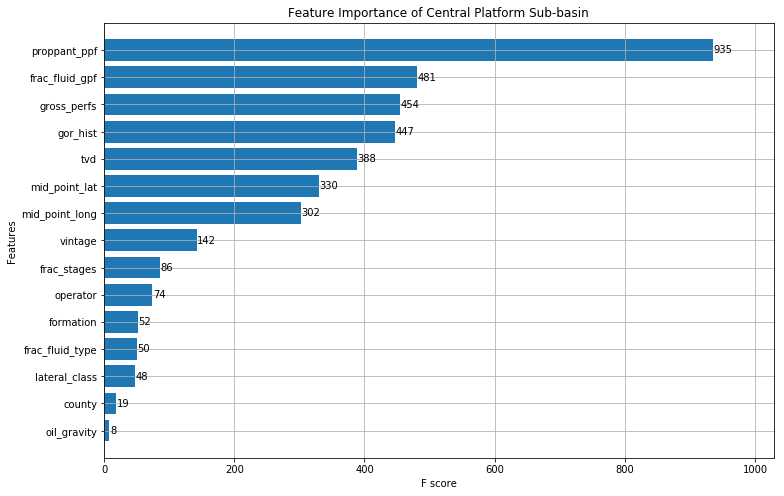

In [93]:
xgb_df = CP_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, CP_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Central Platform Sub-basin')
plt.show()

MAE: 42.86434497747892
MSE: 9107.212133283614
lr.intercept: 61.94109764634948


,value
gross_perfs,135.830415
tvd,130.236055
frac_fluid_gpf,121.938862
gor_hist,107.529077
mid_point_lat,-33.152811
mid_point_long,-124.318633
proppant_ppf,-262.587371


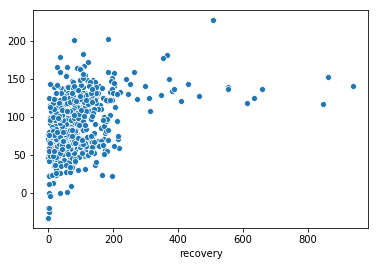

In [94]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gor_hist', 'gross_perfs', 
          'tvd', 'mid_point_lat', 'mid_point_long',]

# Dependent (target) variable, it is continuous
target = ['recovery']

X = CP_df[X_vars].copy()                                                    
y = CP_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [95]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
proppant_ppf,262.587371
gross_perfs,135.830415
tvd,130.236055
mid_point_long,124.318633
frac_fluid_gpf,121.938862
gor_hist,107.529077
mid_point_lat,33.152811


#### Delaware:

In [96]:
Del_df = scaled_df[(scaled_df['sub-basin'] == 0.5)]
Del_df.sample(5)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
7564,0.507548,0.710601,0.348752,0.0,0.000000,0.371044,0.154219,0.381693,0.884621,0.481169,...,0.050964,0.966667,5,0.513514,0.0,0.310606,0.763158,0.250,0.5,0.153846
7517,0.359531,0.441326,0.308389,0.0,0.000000,0.104205,0.206298,0.054184,0.817255,0.467953,...,0.019284,0.950000,5,0.513514,0.0,0.988636,0.763158,0.375,0.5,0.153846
6980,0.016450,0.118006,0.335715,0.0,0.720588,0.169671,0.567013,0.167903,0.544663,0.476542,...,0.089532,0.916667,4,0.189189,0.0,0.174242,0.052632,0.375,0.5,0.153846
7756,0.116932,0.056130,0.012374,0.0,0.000000,0.000319,0.165235,0.000474,0.000000,0.203862,...,0.068871,0.916667,4,0.675676,1.0,0.041667,0.289474,0.375,0.5,0.461538
7438,0.288079,0.338728,0.325919,0.0,0.000000,0.174594,0.140398,0.154461,0.866160,0.431937,...,0.064738,0.950000,5,0.513514,0.0,0.768939,0.763158,0.375,0.5,0.153846


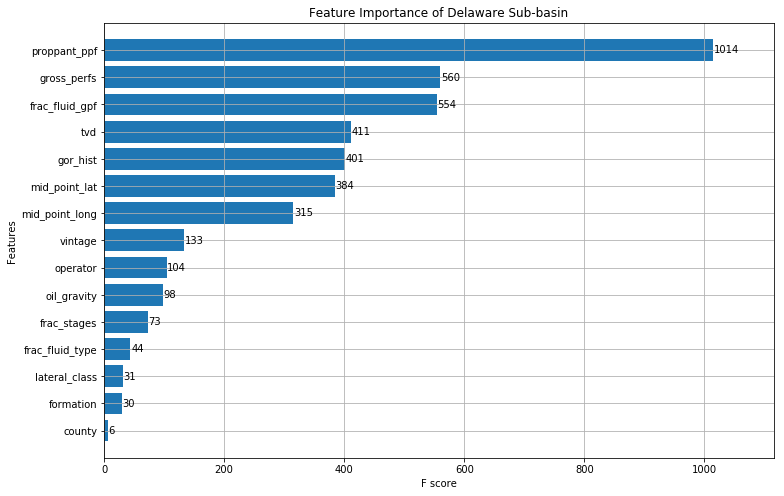

In [97]:
xgb_df = Del_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Del_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Delaware Sub-basin')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

MAE: 78.20664083542087
MSE: 26176.120727194007
lr.intercept: 242.33323796087979


,value
tvd,140.883392
frac_fluid_gpf,139.745562
gor_hist,79.996076
gross_perfs,-0.561685
proppant_ppf,-36.030759
mid_point_lat,-111.000306
mid_point_long,-661.163036


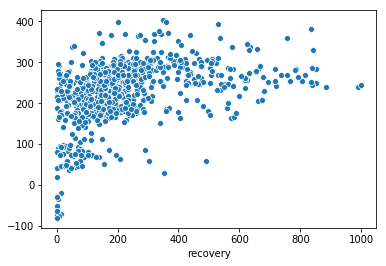

In [98]:
# Independent variables:
X_vars = ['proppant_ppf', 'gross_perfs', 'frac_fluid_gpf', 'gor_hist', 
          'tvd', 'mid_point_lat', 'mid_point_long',]

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Del_df[X_vars].copy()                                                    
y = Del_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [99]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
mid_point_long,661.163036
tvd,140.883392
frac_fluid_gpf,139.745562
mid_point_lat,111.000306
gor_hist,79.996076
proppant_ppf,36.030759
gross_perfs,0.561685


#### Midland:

In [100]:
Mid_df = scaled_df[(scaled_df['sub-basin'] == 1)]
Mid_df.sample(5)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
177,0.286301,0.486544,0.518450,0.000000,0.0,0.070213,0.149786,0.072838,0.494045,0.176845,...,0.108815,0.900000,4,0.162162,0.0,0.015152,0.447368,0.875,1.0,0.000000
2115,0.272902,0.390382,0.702512,0.000000,0.0,0.087347,0.318319,0.093056,0.509975,0.254892,...,0.089532,0.916667,4,0.432432,0.0,0.628788,0.763158,0.375,1.0,0.692308
5543,0.506111,0.387446,0.325624,0.214286,0.0,0.087436,0.144894,0.073015,0.705077,0.351455,...,0.073003,0.933333,5,0.918919,0.0,0.011364,0.763158,0.375,1.0,0.153846
5240,0.446376,0.325272,0.730574,0.014286,0.0,0.000142,0.151846,0.000106,0.522704,0.234419,...,0.000000,1.000000,5,0.702703,0.0,0.734848,0.763158,0.875,1.0,0.692308
4504,0.277638,0.424125,0.512484,0.000000,0.0,0.041816,0.341570,0.050290,0.503796,0.254785,...,0.086777,0.916667,4,0.702703,0.0,0.628788,0.763158,0.875,1.0,0.538462


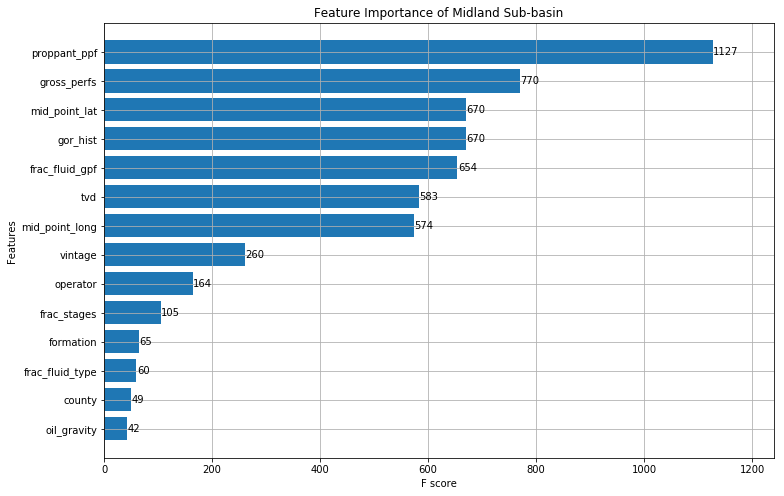

In [101]:
xgb_df = Mid_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat', 'lateral_class']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Midland Sub-basin')
plt.show()

MAE: 46.23830281266067
MSE: 13091.978406892711
lr.intercept: 26.180290012801237


,value
gross_perfs,255.756331
mid_point_lat,147.829013
gor_hist,68.720720
tvd,45.519847
proppant_ppf,2.582827
frac_fluid_gpf,-4.202923
mid_point_long,-112.092155


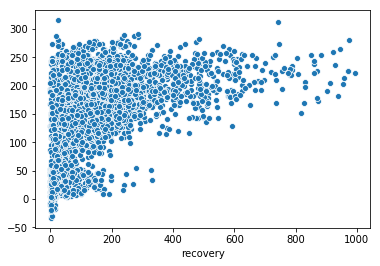

In [102]:
# Independent variables:
X_vars = ['proppant_ppf', 'gross_perfs', 'frac_fluid_gpf', 'mid_point_lat',
          'gor_hist', 'mid_point_long', 'tvd']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_df[X_vars].copy()                                                    
y = Mid_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [103]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
gross_perfs,255.756331
mid_point_lat,147.829013
mid_point_long,112.092155
gor_hist,68.720720
tvd,45.519847
frac_fluid_gpf,4.202923
proppant_ppf,2.582827


#### Midland, horizontal wells only:

In [104]:
scaled_df.direction.value_counts()

0.0    6675
1.0    1213
Name: direction, dtype: int64

In [105]:
Mid_Hor_df = scaled_df[(scaled_df['sub-basin'] == 1) & (scaled_df['direction'] == 0.0)]
Mid_Hor_df.sample(5)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
4506,0.074793,0.126875,0.521396,0.000000,0.0,0.039122,0.291102,0.010644,0.532678,0.360598,...,0.082645,0.933333,5,0.702703,0.0,0.465909,0.631579,0.875,1.0,0.000000
4579,0.275964,0.353429,0.525742,0.342857,0.0,0.016516,0.072619,0.015859,0.651928,0.259082,...,0.082645,0.933333,5,0.702703,0.0,0.628788,0.763158,0.375,1.0,0.000000
5801,0.423261,0.750348,0.883700,0.000000,0.0,0.161949,0.144112,0.175778,0.682448,0.312269,...,0.048209,0.966667,5,0.918919,0.0,0.628788,0.763158,0.375,1.0,0.769231
2011,0.311502,0.573219,0.597997,0.557143,0.0,0.029608,0.490391,0.023836,0.495757,0.196152,...,0.088154,0.916667,4,0.432432,0.0,0.295455,0.763158,0.875,1.0,0.384615
4722,0.277392,0.499541,0.736466,0.000000,0.0,0.103210,0.277832,0.098733,0.574587,0.320194,...,0.071625,0.933333,5,0.702703,0.0,0.465909,0.763158,0.875,1.0,0.076923


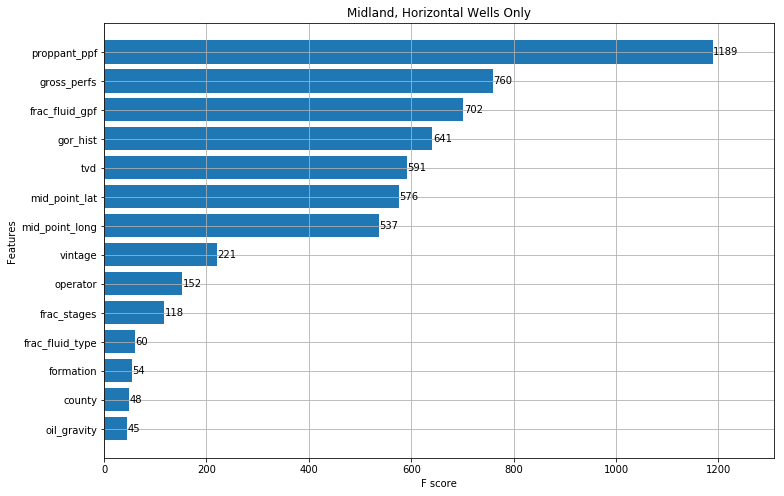

In [106]:
xgb_df = Mid_Hor_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat', 'lateral_class']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells Only')
plt.show()

MAE: 57.722767992181915
MSE: 15493.611038976183
lr.intercept: -184.33154207910314


,value
gross_perfs,284.657157
tvd,182.289773
mid_point_lat,155.469150
gor_hist,57.064352
mid_point_long,25.709977
proppant_ppf,22.783439
frac_fluid_gpf,-0.754349


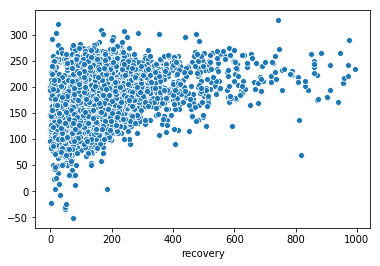

In [107]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'mid_point_lat',
          'gor_hist', 'tvd', 'mid_point_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars].copy()                                                    
y = Mid_Hor_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [108]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
gross_perfs,284.657157
tvd,182.289773
mid_point_lat,155.469150
gor_hist,57.064352
mid_point_long,25.709977
proppant_ppf,22.783439
frac_fluid_gpf,0.754349


#### Midland, vertical wells only:

In [109]:
Mid_Ver_df = scaled_df[(scaled_df['sub-basin'] == 1) & (scaled_df['direction'] == 1.0)]
Mid_Ver_df.sample(5)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
3108,0.057070,0.033069,0.112985,0.000000,0.0,0.005238,0.110826,0.005088,0.0,0.404841,...,0.297521,0.683333,3,0.621622,1.0,0.405303,0.631579,0.375,1.0,1.000000
3866,0.316702,0.167735,0.011416,0.014286,0.0,0.005074,0.125959,0.006006,0.0,0.353629,...,0.378788,0.233333,2,0.702703,1.0,0.628788,0.157895,0.625,1.0,0.461538
3221,0.089749,0.043627,0.112617,0.000000,0.0,0.011180,0.593643,0.011454,0.0,0.390865,...,0.129477,0.850000,4,0.621622,1.0,0.628788,0.631579,0.375,1.0,1.000000
1418,0.092123,0.091068,0.010753,0.000000,0.0,0.001036,0.002875,0.000432,0.0,0.527293,...,0.228650,0.666667,3,0.405405,1.0,0.011364,0.552632,0.250,1.0,0.461538
1540,0.112079,0.043708,0.022833,0.000000,0.0,0.013057,0.012627,0.015153,0.0,0.517183,...,0.276860,0.666667,3,0.405405,1.0,0.712121,0.552632,0.250,1.0,0.461538


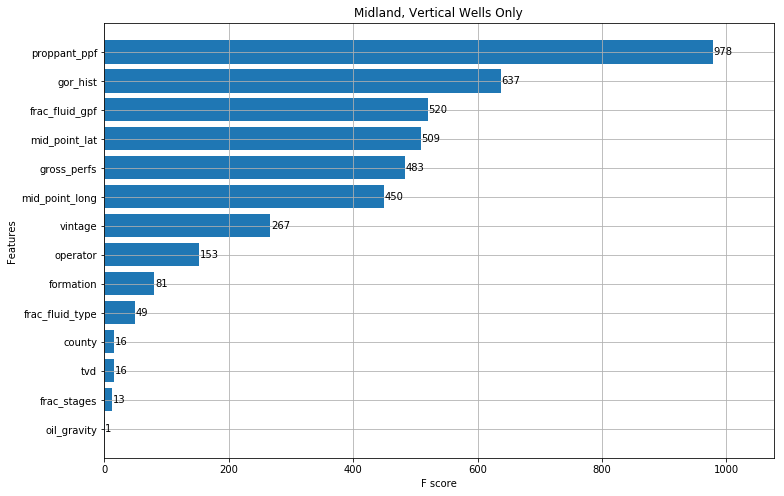

In [110]:
xgb_df = Mid_Ver_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat', 'lateral_class']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Ver_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Vertical Wells Only')
plt.show()

MAE: 14.379812095853742
MSE: 1121.714076558861
lr.intercept: 90.53383578123652


,value
gross_perfs,273.181123
mid_point_lat,77.089645
gor_hist,42.619805
frac_fluid_gpf,29.036997
proppant_ppf,-15.416089
mid_point_long,-60.606163
vintage,-101.870945


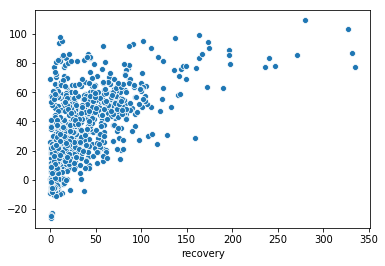

In [111]:
# Independent variables:
X_vars = ['proppant_ppf', 'gor_hist', 'mid_point_long', 'frac_fluid_gpf', 
          'mid_point_lat', 'gross_perfs', 'vintage',]

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Ver_df[X_vars].copy()                                                    
y = Mid_Ver_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [112]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
gross_perfs,273.181123
vintage,101.870945
mid_point_lat,77.089645
mid_point_long,60.606163
gor_hist,42.619805
frac_fluid_gpf,29.036997
proppant_ppf,15.416089


#### Midland, Horizontal Wells, Gross Perforations < 6000:

In [113]:
Mid_Hor_Low_df = scaled_df[(scaled_df['sub-basin'] == 1) & (scaled_df['direction'] == 0.0) & (scaled_df['gross_perfs'] < gross_perfs_scaled_limit)]
Mid_Hor_Low_df.sample(5)

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,sur_lat,...,months_active,vintage,vintage_bin,county,direction,operator,formation,frac_fluid_type,sub-basin,lateral_class
73,0.014916,0.015967,0.238123,0.0,0.0,0.011452,0.042857,0.014118,0.570195,0.664049,...,0.148760,0.866667,4,0.027027,0.0,0.162879,0.631579,0.375,1.0,0.230769
3273,0.283154,0.371947,0.344553,0.0,0.0,0.030830,0.078070,0.032083,0.609126,0.407306,...,0.082645,0.933333,5,0.621622,0.0,0.628788,0.631579,0.375,1.0,0.153846
5573,0.428145,0.572260,0.366134,0.0,0.0,0.085552,0.204204,0.051214,0.706342,0.333319,...,0.020661,0.866667,4,0.918919,0.0,0.196970,0.763158,0.375,1.0,0.153846
2246,0.243741,0.297383,0.346247,0.0,0.0,0.064280,0.396072,0.069937,0.448191,0.199056,...,0.081267,0.933333,5,0.432432,0.0,0.738636,0.763158,0.875,1.0,0.153846
3335,0.312055,0.644119,0.375635,0.0,0.0,0.052353,0.059882,0.063997,0.731725,0.471613,...,0.075758,0.933333,5,0.621622,0.0,0.250000,0.763158,0.875,1.0,0.615385


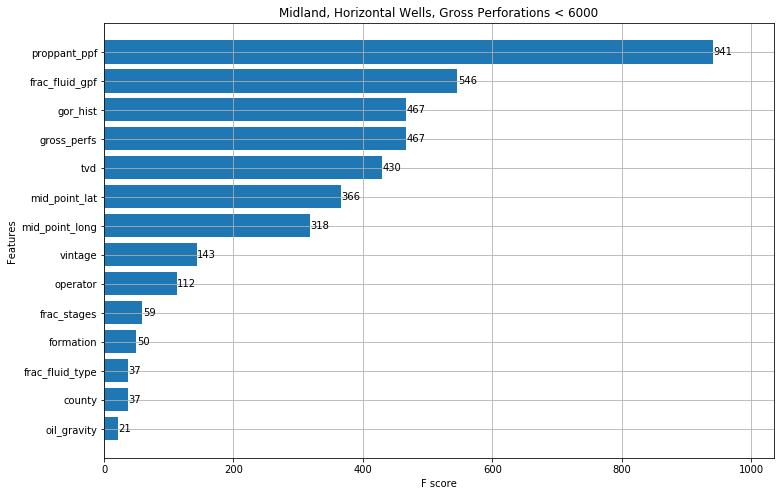

In [114]:
xgb_df = Mid_Hor_Low_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat', 'lateral_class']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_Low_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations < 6000')
plt.show()

MAE: 40.352461006231295
MSE: 6193.007289666208
lr.intercept: 33.81806826346366


,value
gross_perfs,179.336627
tvd,115.429838
gor_hist,68.678897
proppant_ppf,54.193769
mid_point_lat,18.976392
frac_fluid_gpf,0.803713
mid_point_long,-121.051902


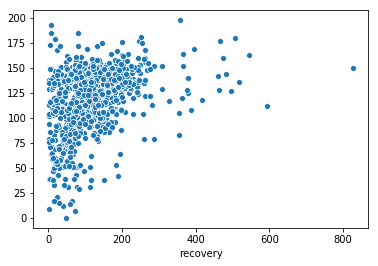

In [115]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'mid_point_lat', 
          'gor_hist', 'tvd', 'mid_point_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_Low_df[X_vars].copy()                                                    
y = Mid_Hor_Low_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [116]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
gross_perfs,179.336627
mid_point_long,121.051902
tvd,115.429838
gor_hist,68.678897
proppant_ppf,54.193769
mid_point_lat,18.976392
frac_fluid_gpf,0.803713


#### Midland, Horizontal Wells, Gross Perforations > 6000:

In [117]:
((scaled_df['sub-basin'] == 1) & (scaled_df['direction'] == 0.0) & (scaled_df['gross_perfs'] < gross_perfs_scaled_limit)).sum()

1144

In [118]:
((scaled_df['sub-basin'] == 1) & (scaled_df['direction'] == 0.0) & (scaled_df['gross_perfs'] > gross_perfs_scaled_limit)).sum()

3841

In [119]:
Mid_Hor_High_df = scaled_df[(scaled_df['sub-basin'] == 1) & (scaled_df['direction'] == 0.0) & (scaled_df['gross_perfs'] > gross_perfs_scaled_limit)]
# Mid_Hor_High_df.sample(5)

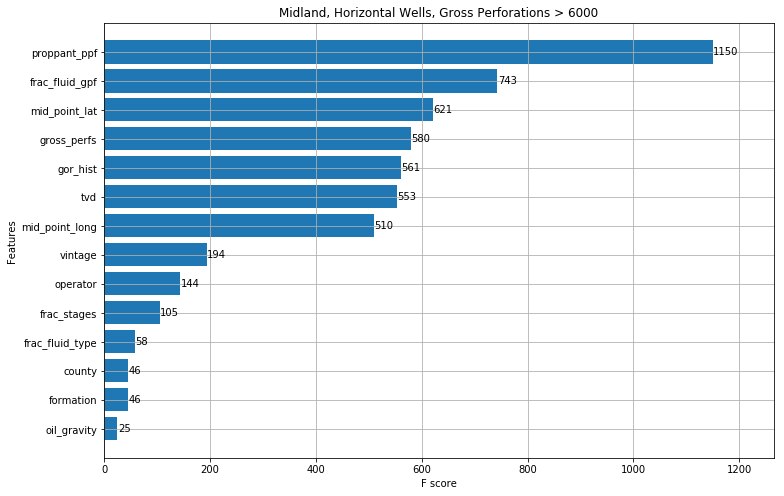

In [120]:
xgb_df = Mid_Hor_High_df.drop(columns=['recovery', 'peak_boepd', 'ip90_boeqpd', 'months_active', 'sur_long','sur_lat', 'lateral_class']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_High_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations > 6000')
plt.show()

MAE: 63.12507493927396
MSE: 17982.569569176085
lr.intercept: -348.6043162061909


,value
tvd,303.646150
gross_perfs,259.018186
mid_point_lat,223.198009
mid_point_long,151.412289
gor_hist,66.423394
frac_fluid_gpf,-0.058033
proppant_ppf,-7.161698


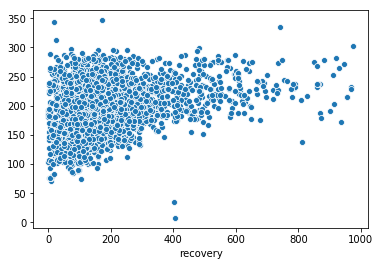

In [121]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'mid_point_lat', 
          'gor_hist', 'tvd', 'mid_point_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_High_df[X_vars].copy()                                                    
y = Mid_Hor_High_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [122]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
tvd,303.646150
gross_perfs,259.018186
mid_point_lat,223.198009
mid_point_long,151.412289
gor_hist,66.423394
proppant_ppf,7.161698
frac_fluid_gpf,0.058033


## Test Harness and Options

# Need to add filter_columns for the following to work.

## Explore and select algorithms

In [ ]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict


In [ ]:
X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
          'months_active', 'lateral_len', 'ip90_boeqpd', 'county']

lregressiontest(scaled_df, X_vars, 'recovery', .8)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering